Using device for inference: cuda
CODE SECURITY DEEP LEARNING PIPELINE
Loaded 1359 samples
Columns (4 total):
  [0]:      import java.security.SecureRandom;
     import javax.crypto.Cipher;
     import javax.crypto.Ke...
  [1]: 4...
  [2]: 0...
  [3]: 262b6bdf80dd616de599361c5bc2d1a3547a736969ccf6d9f2ff5b94a609c0e2...

Auto-detected text column:      import java.security.SecureRandom;
     import javax.crypto.Cipher;
     import javax.crypto.KeyGenerator;
     import javax.crypto.SecretKey;
     import javax.crypto.spec.SecretKeySpec;

     public class SimpleCrypto {

public  String encrypt(String seed, String cleartext) throws Exception {
        byte[] rawKey = getRawKey(seed.getBytes());
        byte[] result = encrypt(rawKey, cleartext.getBytes());
        return toHex(result);
}

public  String decrypt(String seed, String encrypted) throws Exception {
        byte[] rawKey = getRawKey(seed.getBytes());
        byte[] enc = toByte(encrypted);
        byte[] result = decrypt(rawKey,

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./local_codebert_model and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1017 [00:00<?, ? examples/s]


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc,Pr Auc
1,No log,0.426143,0.828431,0.000000,0.000000,0.000000,0.731868,0.406777
2,No log,0.428090,0.828431,0.000000,0.000000,0.000000,0.776500,0.354266
3,No log,0.398477,0.823529,0.470588,0.228571,0.307692,0.775655,0.412104
4,No log,0.393081,0.877451,0.678571,0.542857,0.603175,0.844801,0.568448
5,No log,0.352920,0.906863,0.863636,0.542857,0.666667,0.872358,0.716422
6,No log,0.643608,0.862745,0.594595,0.628571,0.611111,0.856974,0.655249
7,No log,0.518008,0.892157,0.675676,0.714286,0.694444,0.859172,0.739617
8,No log,0.447802,0.892157,0.724138,0.600000,0.656250,0.836010,0.715822
9,No log,0.646417,0.897059,0.750000,0.600000,0.666667,0.855790,0.723784


/home/aditya/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aditya/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



DETAILED MODEL EVALUATION



1. CLASSIFICATION REPORT:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9401    0.9290    0.9345       169
           1     0.6757    0.7143    0.6944        35

    accuracy                         0.8922       204
   macro avg     0.8079    0.8216    0.8145       204
weighted avg     0.8947    0.8922    0.8933       204


2. CONFUSION MATRIX:
----------------------------------------------------------------------
[[157  12]
 [ 10  25]]

Accuracy: 0.8922
Macro F1: 0.8145, Weighted F1: 0.8933
ROC-AUC: 0.8592, PR-AUC: 0.7396
Specificity: 0.9290, Sensitivity: 0.7143

Saving model to ./code_security_results/final_model
Model moved to device: cuda

Generating predictions for question_snippets.csv...
Loaded 2503 question snippets.
Predictions saved to question_snippets.predicts.csv

SAMPLE PREDICTIONS ON QUESTION SNIPPETS

Snippet 1:
Text: private String iv = "MYKEYHERE";//Dummy iv (CHANGE IT!

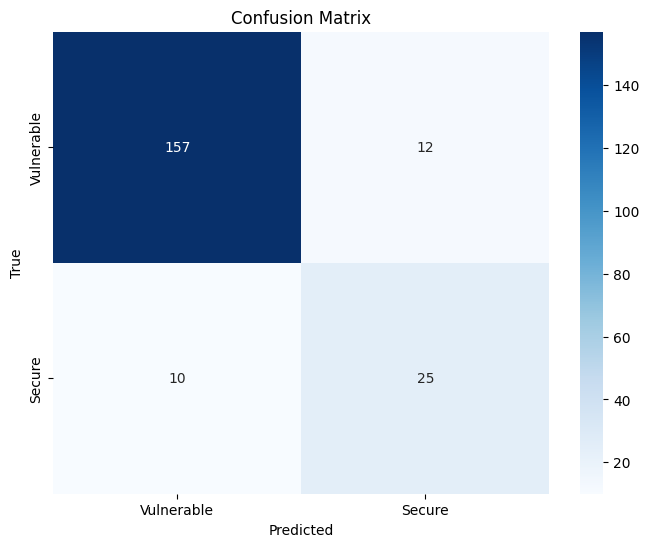

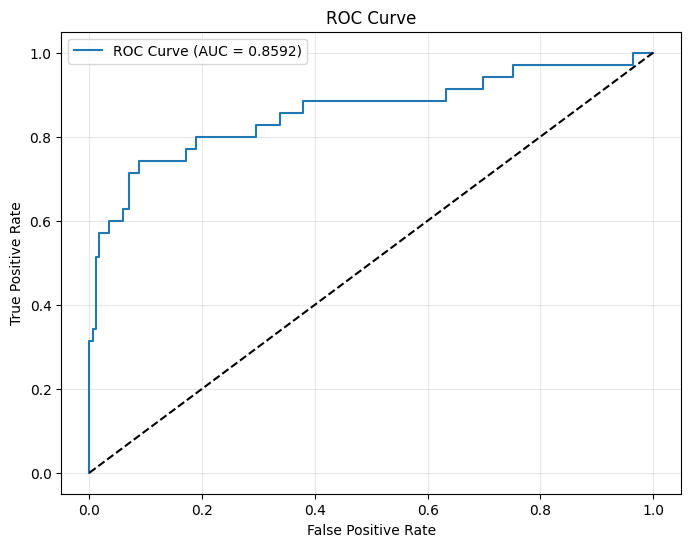

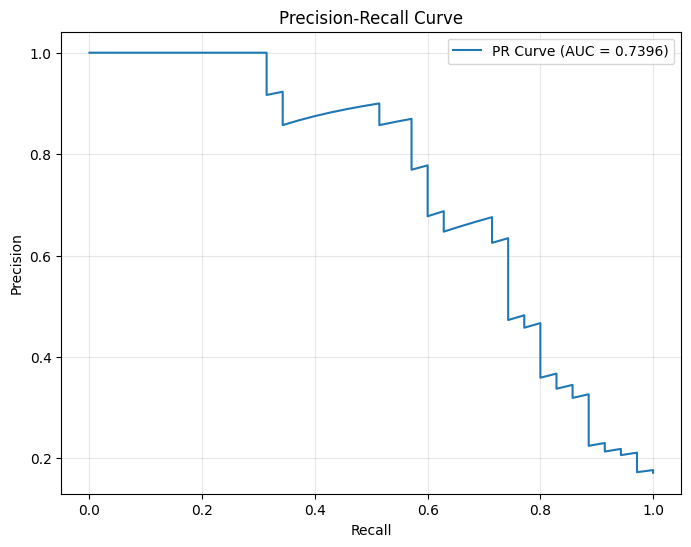

In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ---------------------------
# Load and preprocess data
# ---------------------------
def load_data(filepath, text_column=None, label_column=None):
    """Load CSV file with code snippets and labels"""
    df = pd.read_csv(filepath)
    print(f"Loaded {len(df)} samples")
    print(f"Columns ({len(df.columns)} total):")
    for i, col in enumerate(df.columns):
        print(f"  [{i}]: {col[:100]}...")  # Show first 100 chars of column name

    # Auto-detect columns if not specified
    if text_column is None:
        text_column = df.columns[0]
        print(f"\nAuto-detected text column: {text_column}")

    if label_column is None:
        for col in df.columns[1:]:
            unique_vals = df[col].dropna().unique()
            if len(unique_vals) <= 10 and all(isinstance(v, (int, float, str)) for v in unique_vals):
                label_column = col
                print(f"Auto-detected label column: {label_column}")
                break
        if label_column is None:
            label_column = df.columns[1]
            print(f"Using column {label_column} as label column")

    # Remove NaN values
    df_clean = df[[text_column, label_column]].copy()
    df_clean = df_clean.dropna()

    # Rename columns
    df_clean.columns = ['text', 'label']

    # Convert label to int
    try:
        df_clean['label'] = df_clean['label'].astype(int)
    except:
        unique_labels = df_clean['label'].unique()
        print(f"\nFound non-numeric labels: {unique_labels}")
        label_map = {label: idx for idx, label in enumerate(sorted(unique_labels))}
        print(f"Mapping: {label_map}")
        df_clean['label'] = df_clean['label'].map(label_map)

    # Enforce binary labels (0 = vulnerable, 1 = secure)
    # In your data, scores >=3 are insecure (vulnerable), scores <3 are secure.
    # So, map 0,1,2 -> 1 (Secure), 3,4 -> 0 (Vulnerable)
    df_clean['label'] = df_clean['label'].apply(lambda x: 1 if x < 3 else 0) # Changed mapping

    print(f"\nClass distribution after binary mapping:")
    print(df_clean['label'].value_counts())

    return df_clean

# ---------------------------
# Compute metrics
# ---------------------------
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    probs = torch.softmax(torch.tensor(pred.predictions), dim=-1).numpy()

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)

    try:
        roc_auc = roc_auc_score(labels, probs[:, 1])
    except:
        roc_auc = 0.0

    try:
        pr_auc = average_precision_score(labels, probs[:, 1])
    except:
        pr_auc = 0.0

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

# ---------------------------
# Detailed evaluation
# ---------------------------
def detailed_evaluation(trainer, test_dataset, tokenizer, output_dir='./results'):
    os.makedirs(output_dir, exist_ok=True)

    print("\n" + "="*70)
    print("DETAILED MODEL EVALUATION")
    print("="*70)

    predictions = trainer.predict(test_dataset)
    preds = predictions.predictions.argmax(-1)
    labels = predictions.label_ids
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

    # Classification report
    print("\n1. CLASSIFICATION REPORT:")
    print("-" * 70)
    print(classification_report(labels, preds, digits=4))

    # Confusion matrix
    print("\n2. CONFUSION MATRIX:")
    print("-" * 70)
    cm = confusion_matrix(labels, preds)
    print(cm)

    # Metrics
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, support = precision_recall_fscore_support(labels, preds, average=None)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro')
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    try:
        roc_auc = roc_auc_score(labels, probs[:, 1])
    except:
        roc_auc = 0.0
    try:
        pr_auc = average_precision_score(labels, probs[:, 1])
    except:
        pr_auc = 0.0

    # Specificity & Sensitivity
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Macro F1: {f1_macro:.4f}, Weighted F1: {f1_weighted:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")
    print(f"Specificity: {specificity:.4f}, Sensitivity: {sensitivity:.4f}")

    # Visualizations
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Vulnerable', 'Secure'], yticklabels=['Vulnerable', 'Secure'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'{output_dir}/confusion_matrix.png', dpi=300, bbox_inches='tight')

    fpr, tpr, _ = roc_curve(labels, probs[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(f'{output_dir}/roc_curve.png', dpi=300, bbox_inches='tight')

    precision_curve, recall_curve, _ = precision_recall_curve(labels, probs[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, label=f'PR Curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(f'{output_dir}/precision_recall_curve.png', dpi=300, bbox_inches='tight')

    return {
        'accuracy': accuracy,
        'precision': precision_weighted,
        'recall': recall_weighted,
        'f1': f1_weighted,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm
    }

# ---------------------------
# Train BERT model
# ---------------------------
def train_bert_model(df, output_dir='./results', model_name='./local_codebert_model'):
    os.makedirs(output_dir, exist_ok=True)

    # Ensure the local model path exists
    if not os.path.isdir(model_name):
        raise FileNotFoundError(f"Local model directory not found: {model_name}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

    dataset = Dataset.from_pandas(df[['text', 'label']])
    tokenized_dataset = dataset.map(tokenize_function, batched=True)

    train_test = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
    train_dataset = train_test['train']
    test_dataset = train_test['test']

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=20,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        # --- MODIFIED LOGGING ---
        logging_dir=f'{output_dir}/logs',
        logging_strategy="no", # Disable logging to potentially avoid progress update errors
        # logging_steps=50, # Commented out
        # --- END MODIFIED LOGGING ---
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        save_total_limit=2
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    print("\nStarting training...")
    trainer.train()

    metrics = detailed_evaluation(trainer, test_dataset, tokenizer, output_dir)

    print(f"\nSaving model to {output_dir}/final_model")
    model.save_pretrained(f'{output_dir}/final_model')
    tokenizer.save_pretrained(f'{output_dir}/final_model')

    return model, tokenizer, trainer, metrics

# ---------------------------
# Prediction function (CORRECTED for GPU)
# ---------------------------
def predict_code_security(model, tokenizer, code_snippet):
    # Get the device the model is currently on
    device = next(model.parameters()).device

    # Tokenize the input
    inputs = tokenizer(code_snippet, return_tensors='pt', truncation=True, max_length=512, padding=True)
    # Move the input tensors to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Perform prediction
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][prediction].item()

    result = "SECURE" if prediction == 1 else "VULNERABLE"
    return result, confidence * 100, probs[0].tolist()

# ---------------------------
# Generate Predictions for Question Snippets
# ---------------------------
def generate_predictions_for_questions(model, tokenizer, question_file, output_file):
    """Generate predictions for snippets in question_file and save to output_file."""
    print(f"\nGenerating predictions for {question_file}...")

    # Load question snippets
    df_questions = pd.read_csv(question_file)
    print(f"Loaded {len(df_questions)} question snippets.")

    # Create a new column for predictions
    predictions = []
    confidences = []
    prob_vul = []
    prob_sec = []

    # Assuming the text column is the first one
    text_column = df_questions.columns[0]

    for snippet in df_questions[text_column]:
        result, confidence, probs = predict_code_security(model, tokenizer, snippet)
        predictions.append(result)
        confidences.append(confidence)
        prob_vul.append(probs[0]) # Probability of Vulnerable (class 0)
        prob_sec.append(probs[1]) # Probability of Secure (class 1)

    # Add predictions to the dataframe
    df_questions['prediction'] = predictions
    df_questions['confidence'] = confidences
    df_questions['prob_vulnerable'] = prob_vul
    df_questions['prob_secure'] = prob_sec

    # Save to file
    df_questions.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

    return df_questions

# ---------------------------
# Main function
# ---------------------------
def main():
    TRAINING_FILE = 'answer_snippets.annotations.csv'
    QUESTION_FILE = 'question_snippets.csv'
    OUTPUT_DIR = './code_security_results'
    # Define device explicitly
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device for inference: {DEVICE}")

    print("="*70)
    print("CODE SECURITY DEEP LEARNING PIPELINE")
    print("="*70)

    # Load and prepare training data
    df_train = load_data(TRAINING_FILE)

    # Train the model
    model, tokenizer, trainer, metrics = train_bert_model(df_train, OUTPUT_DIR)

    # --- MOVE MODEL TO GPU AFTER TRAINING (CRITICAL FOR PREDICTION) ---
    model = model.to(DEVICE)
    print(f"Model moved to device: {DEVICE}")
    # ----------------------------------------

    # Generate predictions for question snippets
    PREDICTION_OUTPUT_FILE = 'question_snippets.predicts.csv'
    df_predictions = generate_predictions_for_questions(model, tokenizer, QUESTION_FILE, PREDICTION_OUTPUT_FILE)

    # Optionally, show some sample predictions
    print("\n" + "="*70)
    print("SAMPLE PREDICTIONS ON QUESTION SNIPPETS")
    print("="*70)
    sample_size = min(5, len(df_predictions))
    for i in range(sample_size):
        snippet = df_predictions.iloc[i][df_predictions.columns[0]]
        pred = df_predictions.iloc[i]['prediction']
        conf = df_predictions.iloc[i]['confidence']
        prob_vul = df_predictions.iloc[i]['prob_vulnerable']
        prob_sec = df_predictions.iloc[i]['prob_secure']
        print(f"\nSnippet {i+1}:")
        print(f"Text: {snippet[:100]}..." if len(snippet) > 100 else snippet)
        print(f"Prediction: {pred} (Confidence: {conf:.2f}%)")
        print(f"Probabilities: Vulnerable={prob_vul:.4f}, Secure={prob_sec:.4f}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETE!")
    print("="*70)

if __name__ == "__main__":
    main()

Using device for inference: cuda
CODE SECURITY DEEP LEARNING PIPELINE
Loaded 1359 samples
Columns (4 total):
  [0]:      import java.security.SecureRandom;
     import javax.crypto.Cipher;
     import javax.crypto.Ke...
  [1]: 4...
  [2]: 0...
  [3]: 262b6bdf80dd616de599361c5bc2d1a3547a736969ccf6d9f2ff5b94a609c0e2...

Auto-detected text column:      import java.security.SecureRandom;
     import javax.crypto.Cipher;
     import javax.crypto.KeyGenerator;
     import javax.crypto.SecretKey;
     import javax.crypto.spec.SecretKeySpec;

     public class SimpleCrypto {

public  String encrypt(String seed, String cleartext) throws Exception {
        byte[] rawKey = getRawKey(seed.getBytes());
        byte[] result = encrypt(rawKey, cleartext.getBytes());
        return toHex(result);
}

public  String decrypt(String seed, String encrypted) throws Exception {
        byte[] rawKey = getRawKey(seed.getBytes());
        byte[] enc = toByte(encrypted);
        byte[] result = decrypt(rawKey,

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./local_codebert_model and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1017 [00:00<?, ? examples/s]


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc,Pr Auc
1,No log,0.420297,0.828431,0.000000,0.000000,0.000000,0.715976,0.401407
2,No log,0.413933,0.803922,0.000000,0.000000,0.000000,0.748774,0.306300
3,No log,0.416401,0.759804,0.365385,0.542857,0.436782,0.785968,0.399908
4,No log,0.387013,0.897059,0.718750,0.657143,0.686567,0.845139,0.575250
5,No log,0.342573,0.887255,0.772727,0.485714,0.596491,0.873542,0.665473


/home/aditya/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



DETAILED MODEL EVALUATION



1. CLASSIFICATION REPORT:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9302    0.9467    0.9384       169
           1     0.7188    0.6571    0.6866        35

    accuracy                         0.8971       204
   macro avg     0.8245    0.8019    0.8125       204
weighted avg     0.8939    0.8971    0.8952       204


2. CONFUSION MATRIX:
----------------------------------------------------------------------
[[160   9]
 [ 12  23]]

Accuracy: 0.8971
Macro F1: 0.8125, Weighted F1: 0.8952
ROC-AUC: 0.8451, PR-AUC: 0.5753
Specificity: 0.9467, Sensitivity: 0.6571

Saving model to ./code_security_results/final_model
Model moved to device: cuda

Generating predictions for question_snippets.csv...
Loaded 2503 question snippets.
Predictions saved to question_snippets.predicts.csv

SAMPLE PREDICTIONS ON QUESTION SNIPPETS

Snippet 1:
Text: private String iv = "MYKEYHERE";//Dummy iv (CHANGE IT!

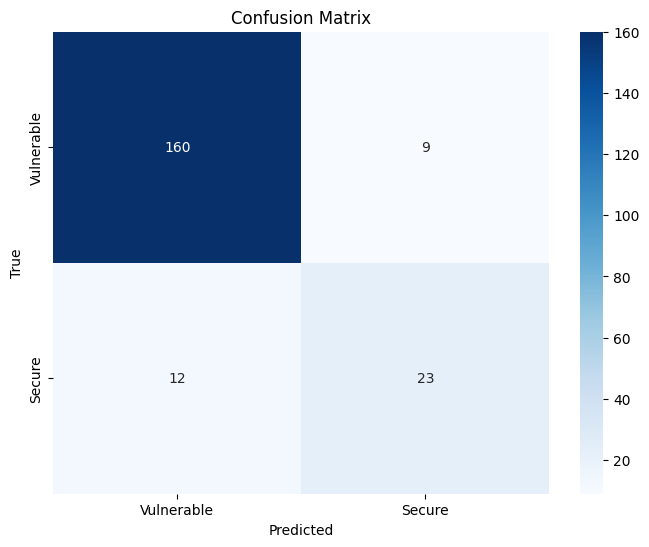

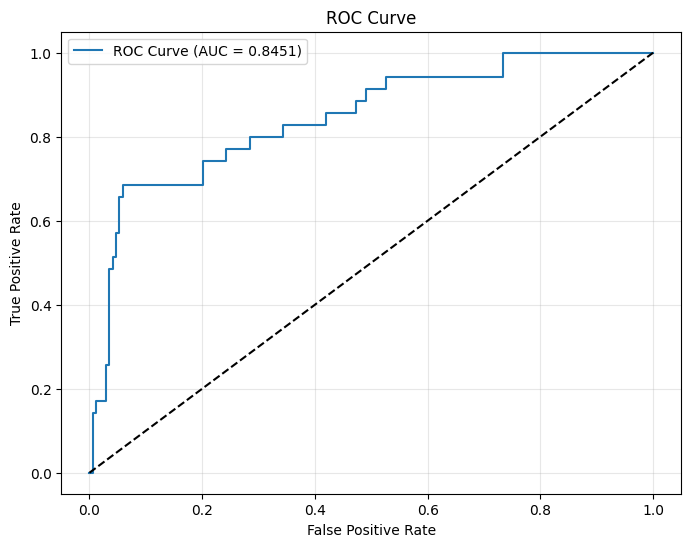

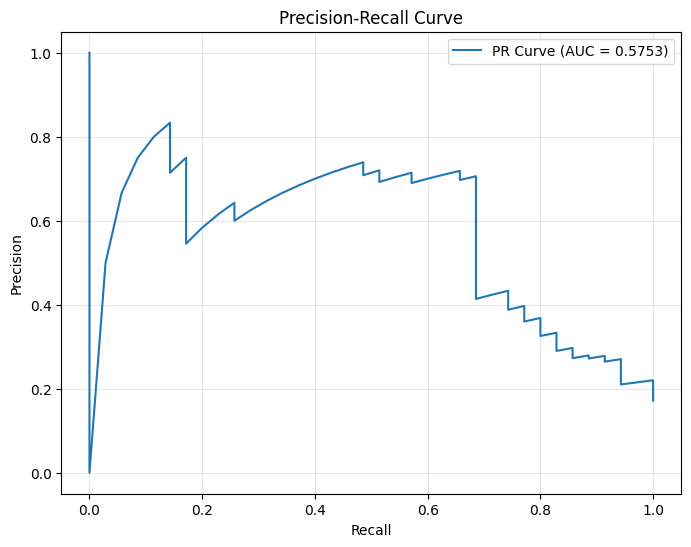

In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ---------------------------
# Load and preprocess data
# ---------------------------
def load_data(filepath, text_column=None, label_column=None):
    """Load CSV file with code snippets and labels"""
    df = pd.read_csv(filepath)
    print(f"Loaded {len(df)} samples")
    print(f"Columns ({len(df.columns)} total):")
    for i, col in enumerate(df.columns):
        print(f"  [{i}]: {col[:100]}...")  # Show first 100 chars of column name

    # Auto-detect columns if not specified
    if text_column is None:
        text_column = df.columns[0]
        print(f"\nAuto-detected text column: {text_column}")

    if label_column is None:
        for col in df.columns[1:]:
            unique_vals = df[col].dropna().unique()
            if len(unique_vals) <= 10 and all(isinstance(v, (int, float, str)) for v in unique_vals):
                label_column = col
                print(f"Auto-detected label column: {label_column}")
                break
        if label_column is None:
            label_column = df.columns[1]
            print(f"Using column {label_column} as label column")

    # Remove NaN values
    df_clean = df[[text_column, label_column]].copy()
    df_clean = df_clean.dropna()

    # Rename columns
    df_clean.columns = ['text', 'label']

    # Convert label to int
    try:
        df_clean['label'] = df_clean['label'].astype(int)
    except:
        unique_labels = df_clean['label'].unique()
        print(f"\nFound non-numeric labels: {unique_labels}")
        label_map = {label: idx for idx, label in enumerate(sorted(unique_labels))}
        print(f"Mapping: {label_map}")
        df_clean['label'] = df_clean['label'].map(label_map)

    # Enforce binary labels (0 = vulnerable, 1 = secure)
    # In your data, scores >=3 are insecure (vulnerable), scores <3 are secure.
    # So, map 0,1,2 -> 1 (Secure), 3,4 -> 0 (Vulnerable)
    df_clean['label'] = df_clean['label'].apply(lambda x: 1 if x < 3 else 0) # Changed mapping

    print(f"\nClass distribution after binary mapping:")
    print(df_clean['label'].value_counts())

    return df_clean

# ---------------------------
# Compute metrics
# ---------------------------
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    probs = torch.softmax(torch.tensor(pred.predictions), dim=-1).numpy()

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)

    try:
        roc_auc = roc_auc_score(labels, probs[:, 1])
    except:
        roc_auc = 0.0

    try:
        pr_auc = average_precision_score(labels, probs[:, 1])
    except:
        pr_auc = 0.0

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

# ---------------------------
# Detailed evaluation
# ---------------------------
def detailed_evaluation(trainer, test_dataset, tokenizer, output_dir='./results'):
    os.makedirs(output_dir, exist_ok=True)

    print("\n" + "="*70)
    print("DETAILED MODEL EVALUATION")
    print("="*70)

    predictions = trainer.predict(test_dataset)
    preds = predictions.predictions.argmax(-1)
    labels = predictions.label_ids
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

    # Classification report
    print("\n1. CLASSIFICATION REPORT:")
    print("-" * 70)
    print(classification_report(labels, preds, digits=4))

    # Confusion matrix
    print("\n2. CONFUSION MATRIX:")
    print("-" * 70)
    cm = confusion_matrix(labels, preds)
    print(cm)

    # Metrics
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, support = precision_recall_fscore_support(labels, preds, average=None)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro')
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    try:
        roc_auc = roc_auc_score(labels, probs[:, 1])
    except:
        roc_auc = 0.0
    try:
        pr_auc = average_precision_score(labels, probs[:, 1])
    except:
        pr_auc = 0.0

    # Specificity & Sensitivity
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Macro F1: {f1_macro:.4f}, Weighted F1: {f1_weighted:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")
    print(f"Specificity: {specificity:.4f}, Sensitivity: {sensitivity:.4f}")

    # Visualizations
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Vulnerable', 'Secure'], yticklabels=['Vulnerable', 'Secure'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'{output_dir}/confusion_matrix.png', dpi=300, bbox_inches='tight')

    fpr, tpr, _ = roc_curve(labels, probs[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(f'{output_dir}/roc_curve.png', dpi=300, bbox_inches='tight')

    precision_curve, recall_curve, _ = precision_recall_curve(labels, probs[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, label=f'PR Curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(f'{output_dir}/precision_recall_curve.png', dpi=300, bbox_inches='tight')

    return {
        'accuracy': accuracy,
        'precision': precision_weighted,
        'recall': recall_weighted,
        'f1': f1_weighted,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm
    }

# ---------------------------
# Train BERT model
# ---------------------------
def train_bert_model(df, output_dir='./results', model_name='./local_codebert_model'):
    os.makedirs(output_dir, exist_ok=True)

    # Ensure the local model path exists
    if not os.path.isdir(model_name):
        raise FileNotFoundError(f"Local model directory not found: {model_name}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

    dataset = Dataset.from_pandas(df[['text', 'label']])
    tokenized_dataset = dataset.map(tokenize_function, batched=True)

    train_test = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
    train_dataset = train_test['train']
    test_dataset = train_test['test']

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        # --- MODIFIED LOGGING ---
        logging_dir=f'{output_dir}/logs',
        logging_strategy="no", # Disable logging to potentially avoid progress update errors
        # logging_steps=50, # Commented out
        # --- END MODIFIED LOGGING ---
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        save_total_limit=2
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    print("\nStarting training...")
    trainer.train()

    metrics = detailed_evaluation(trainer, test_dataset, tokenizer, output_dir)

    print(f"\nSaving model to {output_dir}/final_model")
    model.save_pretrained(f'{output_dir}/final_model')
    tokenizer.save_pretrained(f'{output_dir}/final_model')

    return model, tokenizer, trainer, metrics

# ---------------------------
# Prediction function (CORRECTED for GPU)
# ---------------------------
def predict_code_security(model, tokenizer, code_snippet):
    # Get the device the model is currently on
    device = next(model.parameters()).device

    # Tokenize the input
    inputs = tokenizer(code_snippet, return_tensors='pt', truncation=True, max_length=512, padding=True)
    # Move the input tensors to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Perform prediction
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][prediction].item()

    result = "SECURE" if prediction == 1 else "VULNERABLE"
    return result, confidence * 100, probs[0].tolist()

# ---------------------------
# Generate Predictions for Question Snippets
# ---------------------------
def generate_predictions_for_questions(model, tokenizer, question_file, output_file):
    """Generate predictions for snippets in question_file and save to output_file."""
    print(f"\nGenerating predictions for {question_file}...")

    # Load question snippets
    df_questions = pd.read_csv(question_file)
    print(f"Loaded {len(df_questions)} question snippets.")

    # Create a new column for predictions
    predictions = []
    confidences = []
    prob_vul = []
    prob_sec = []

    # Assuming the text column is the first one
    text_column = df_questions.columns[0]

    for snippet in df_questions[text_column]:
        result, confidence, probs = predict_code_security(model, tokenizer, snippet)
        predictions.append(result)
        confidences.append(confidence)
        prob_vul.append(probs[0]) # Probability of Vulnerable (class 0)
        prob_sec.append(probs[1]) # Probability of Secure (class 1)

    # Add predictions to the dataframe
    df_questions['prediction'] = predictions
    df_questions['confidence'] = confidences
    df_questions['prob_vulnerable'] = prob_vul
    df_questions['prob_secure'] = prob_sec

    # Save to file
    df_questions.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

    return df_questions

# ---------------------------
# Main function
# ---------------------------
def main():
    TRAINING_FILE = 'answer_snippets.annotations.csv'
    QUESTION_FILE = 'question_snippets.csv'
    OUTPUT_DIR = './code_security_results'
    # Define device explicitly
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device for inference: {DEVICE}")

    print("="*70)
    print("CODE SECURITY DEEP LEARNING PIPELINE")
    print("="*70)

    # Load and prepare training data
    df_train = load_data(TRAINING_FILE)

    # Train the model
    model, tokenizer, trainer, metrics = train_bert_model(df_train, OUTPUT_DIR)

    # --- MOVE MODEL TO GPU AFTER TRAINING (CRITICAL FOR PREDICTION) ---
    model = model.to(DEVICE)
    print(f"Model moved to device: {DEVICE}")
    # ----------------------------------------

    # Generate predictions for question snippets
    PREDICTION_OUTPUT_FILE = 'question_snippets.predicts.csv'
    df_predictions = generate_predictions_for_questions(model, tokenizer, QUESTION_FILE, PREDICTION_OUTPUT_FILE)

    # Optionally, show some sample predictions
    print("\n" + "="*70)
    print("SAMPLE PREDICTIONS ON QUESTION SNIPPETS")
    print("="*70)
    sample_size = min(5, len(df_predictions))
    for i in range(sample_size):
        snippet = df_predictions.iloc[i][df_predictions.columns[0]]
        pred = df_predictions.iloc[i]['prediction']
        conf = df_predictions.iloc[i]['confidence']
        prob_vul = df_predictions.iloc[i]['prob_vulnerable']
        prob_sec = df_predictions.iloc[i]['prob_secure']
        print(f"\nSnippet {i+1}:")
        print(f"Text: {snippet[:100]}..." if len(snippet) > 100 else snippet)
        print(f"Prediction: {pred} (Confidence: {conf:.2f}%)")
        print(f"Probabilities: Vulnerable={prob_vul:.4f}, Secure={prob_sec:.4f}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETE!")
    print("="*70)

if __name__ == "__main__":
    main()

In [4]:
import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ---------------------------
# Load and preprocess data
# ---------------------------
def load_data(filepath, text_column=None, label_column=None):
    """Load CSV file with code snippets and labels"""
    df = pd.read_csv(filepath)
    print(f"Loaded {len(df)} samples")
    print(f"Columns ({len(df.columns)} total):")
    for i, col in enumerate(df.columns):
        # Handle potential non-string column names gracefully
        try:
            col_name_str = str(col)[:100]
        except Exception:
            col_name_str = f"Column_{i}"
        print(f"  [{i}]: {col_name_str}...") # Show first 100 chars

    # Auto-detect columns if not specified
    if text_column is None:
        text_column = df.columns[0]
        print(f"\nAuto-detected text column: {text_column}")

    if label_column is None:
        for col in df.columns[1:]:
            try:
                unique_vals = df[col].dropna().unique()
                if len(unique_vals) <= 10 and all(isinstance(v, (int, float, str)) for v in unique_vals):
                    label_column = col
                    print(f"Auto-detected label column: {label_column}")
                    break
            except Exception as e:
                print(f"Could not analyze column {col} for auto-detection: {e}")
        if label_column is None:
            label_column = df.columns[1] # Fallback
            print(f"Using column {label_column} as label column (fallback)")

    # Ensure selected columns exist
    if text_column not in df.columns:
        raise ValueError(f"Text column '{text_column}' not found in the CSV.")
    if label_column not in df.columns:
         raise ValueError(f"Label column '{label_column}' not found in the CSV.")

    # Remove NaN values specifically from the selected columns
    df_clean = df[[text_column, label_column]].copy()
    initial_rows = len(df_clean)
    df_clean = df_clean.dropna(subset=[text_column, label_column])
    dropped_rows = initial_rows - len(df_clean)
    if dropped_rows > 0:
        print(f"Dropped {dropped_rows} rows with NaN values in text or label columns.")


    # Rename columns
    df_clean.columns = ['text', 'label']

    # Convert label to int
    try:
        df_clean['label'] = df_clean['label'].astype(int)
    except ValueError: # Handle cases where labels might be strings like 'Secure' initially
        unique_labels = df_clean['label'].unique()
        print(f"\nFound non-numeric labels: {unique_labels}")
        # Attempt to map common security terms or use alphabetical order
        if 'Secure' in unique_labels or 'Vulnerable' in unique_labels:
             label_map = {'Secure': 1, 'Vulnerable': 0}
             # Add mappings for other potential labels if they exist
             other_labels = sorted([l for l in unique_labels if l not in label_map])
             for i, label in enumerate(other_labels, start=max(label_map.values()) + 1 if label_map else 0):
                 label_map[label] = i
        else:
            # Fallback to alphabetical mapping if specific terms aren't found
            label_map = {label: idx for idx, label in enumerate(sorted(unique_labels))}

        print(f"Attempting mapping: {label_map}")
        df_clean['label'] = df_clean['label'].map(label_map)
        # Verify conversion worked
        if df_clean['label'].isnull().any():
             raise ValueError("Label mapping resulted in NaN values. Check label consistency.")
        df_clean['label'] = df_clean['label'].astype(int)


    # --- Crucial Binary Mapping ---
    # Assuming original labels were scores: 0,1,2 = Secure (map to 1), 3,4 = Vulnerable (map to 0)
    # If the labels were already 0/1, ensure they match this convention.
    print(f"\nOriginal unique labels before binary mapping: {df_clean['label'].unique()}")
    df_clean['label'] = df_clean['label'].apply(lambda x: 1 if x < 3 else 0)
    # --- End Crucial Mapping ---

    print(f"\nClass distribution after binary mapping (0=Vulnerable, 1=Secure):")
    print(df_clean['label'].value_counts())

    # Ensure only 0 and 1 are present
    final_unique_labels = df_clean['label'].unique()
    if not all(label in [0, 1] for label in final_unique_labels):
        raise ValueError(f"Binary mapping failed. Final labels are: {final_unique_labels}. Expected only 0 and 1.")


    return df_clean

# ---------------------------
# Compute metrics
# ---------------------------
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Ensure predictions are valid before calculating metrics
    if labels is None or preds is None or len(labels) == 0 or len(preds) == 0:
        return {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'roc_auc': 0, 'pr_auc': 0}

    # Handle potential probability tensor format issues
    try:
         probs_tensor = torch.tensor(pred.predictions)
         # Ensure it's 2D [batch_size, num_classes]
         if probs_tensor.ndim == 1:
              # Handle potential edge case where output might be squeezed
              probs_tensor = probs_tensor.unsqueeze(0)
         if probs_tensor.shape[1] != 2:
              raise ValueError(f"Expected 2 classes in predictions, but got shape {probs_tensor.shape}")
         probs = torch.softmax(probs_tensor, dim=-1).numpy()
    except Exception as e:
         print(f"Warning: Could not calculate probabilities reliably. {e}")
         # Provide dummy probabilities if softmax fails
         probs = np.zeros((len(labels), 2))
         probs[:, 0] = 1.0 - preds # Assign probability based on prediction
         probs[:, 1] = preds

    # Calculate metrics with zero_division handling
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)

    roc_auc = 0.0
    pr_auc = 0.0
    # Ensure there are both classes present for AUC calculations
    if len(np.unique(labels)) > 1:
        try:
            # Use probability of the positive class (Secure=1)
            roc_auc = roc_auc_score(labels, probs[:, 1])
        except ValueError as e:
            print(f"Warning: ROC AUC calculation failed. {e}") # Usually due to only one class present
            roc_auc = 0.0
        try:
            pr_auc = average_precision_score(labels, probs[:, 1])
        except ValueError as e:
            print(f"Warning: PR AUC calculation failed. {e}")
            pr_auc = 0.0
    else:
        print("Warning: Only one class present in labels. ROC AUC and PR AUC set to 0.0")


    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

# ---------------------------
# Detailed evaluation
# ---------------------------
def detailed_evaluation(trainer, test_dataset, tokenizer, output_dir='./results'):
    os.makedirs(output_dir, exist_ok=True)

    print("\n" + "="*70)
    print("DETAILED MODEL EVALUATION")
    print("="*70)

    try:
        predictions_output = trainer.predict(test_dataset)
    except Exception as e:
        print(f"Error during prediction: {e}")
        return {} # Return empty dict or handle error appropriately

    preds = predictions_output.predictions.argmax(-1)
    labels = predictions_output.label_ids

    if labels is None or preds is None or len(labels) == 0 or len(preds) == 0:
        print("Error: No labels or predictions found for detailed evaluation.")
        return {}

    # Calculate probabilities
    try:
        probs_tensor = torch.tensor(predictions_output.predictions)
        if probs_tensor.ndim == 1: probs_tensor = probs_tensor.unsqueeze(0)
        if probs_tensor.shape[1] != 2: raise ValueError("Invalid shape")
        probs = torch.softmax(probs_tensor, dim=-1).numpy()
    except Exception as e:
        print(f"Warning: Could not reliably calculate probabilities for detailed eval. {e}")
        probs = np.zeros((len(labels), 2))
        probs[:, 0] = 1.0 - preds
        probs[:, 1] = preds


    # Classification report
    print("\n1. CLASSIFICATION REPORT:")
    print("-" * 70)
    # Ensure target names match the label mapping (0=Vuln, 1=Secure)
    print(classification_report(labels, preds, target_names=['Vulnerable', 'Secure'], digits=4, zero_division=0))

    # Confusion matrix
    print("\n2. CONFUSION MATRIX:")
    print("-" * 70)
    cm = confusion_matrix(labels, preds)
    # Ensure the matrix has the expected 2x2 shape, handle case with only one class predicted
    if cm.shape == (1, 1):
         # If only one class is present in both labels and predictions
         if np.unique(labels).item() == 0: # Only Vulnerable
             cm_full = np.array([[cm[0,0], 0], [0, 0]])
         else: # Only Secure
             cm_full = np.array([[0, 0], [0, cm[0,0]]])
         print(f"Warning: Only one class found. Expanded confusion matrix:\n{cm_full}")
         cm = cm_full # Use the expanded matrix for calculations below
    elif cm.shape != (2, 2):
         # Handle unexpected shapes if necessary, though less likely with binary classification
         print(f"Warning: Unexpected confusion matrix shape {cm.shape}. Metrics might be inaccurate.")
         # Attempt to pad if reasonable, otherwise metrics below might fail
         # This padding assumes the existing matrix corresponds to the top-left if smaller
         if cm.shape == (1, 2): # One true class, two predicted
             if np.unique(labels).item() == 0: # True class is 0
                 cm = np.vstack([cm, [0, 0]])
             else: # True class is 1
                 cm = np.vstack([[0, 0], cm])
         elif cm.shape == (2, 1): # Two true classes, one predicted
             if np.unique(preds).item() == 0: # Predicted class is 0
                 cm = np.hstack([cm, [[0],[0]]])
             else: # Predicted class is 1
                 cm = np.hstack([[[0],[0]], cm])
         # Re-calculate ravel based on potentially adjusted cm
         if cm.shape != (2,2):
             print("Error: Could not adjust confusion matrix to 2x2. Skipping TN/FP/FN/TP calculation.")
             tn, fp, fn, tp = 0, 0, 0, 0
         else:
             tn, fp, fn, tp = cm.ravel()

    else:
        tn, fp, fn, tp = cm.ravel() # Standard case


    print(cm)


    # Metrics (recalculate here for consistency)
    accuracy = accuracy_score(labels, preds)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)

    roc_auc = 0.0
    pr_auc = 0.0
    if len(np.unique(labels)) > 1:
        try:
            roc_auc = roc_auc_score(labels, probs[:, 1])
            pr_auc = average_precision_score(labels, probs[:, 1])
        except ValueError:
             print("Warning: Could not calculate AUC scores, likely due to single class.")
             pass # Keep as 0.0

    # Specificity & Sensitivity from potentially adjusted cm
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0 # Recall is the same as sensitivity

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Macro F1: {f1_macro:.4f}, Weighted F1: {f1_weighted:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")
    print(f"Specificity: {specificity:.4f}, Sensitivity: {sensitivity:.4f}")

    # Visualizations
    try:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Vulnerable', 'Secure'], yticklabels=['Vulnerable', 'Secure'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f'{output_dir}/confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.close() # Close plot

        # Only plot ROC/PR if AUC > 0 (meaning >1 class was present)
        if roc_auc > 0:
            fpr, tpr, _ = roc_curve(labels, probs[:, 1])
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend()
            plt.grid(alpha=0.3)
            plt.savefig(f'{output_dir}/roc_curve.png', dpi=300, bbox_inches='tight')
            plt.close() # Close plot

        if pr_auc > 0:
            precision_curve, recall_curve, _ = precision_recall_curve(labels, probs[:, 1])
            plt.figure(figsize=(8, 6))
            plt.plot(recall_curve, precision_curve, label=f'PR Curve (AUC = {pr_auc:.4f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.legend()
            plt.grid(alpha=0.3)
            plt.savefig(f'{output_dir}/precision_recall_curve.png', dpi=300, bbox_inches='tight')
            plt.close() # Close plot

    except Exception as e:
        print(f"Error generating plots: {e}")


    return {
        'accuracy': accuracy,
        'precision': precision_weighted,
        'recall': recall_weighted,
        'f1': f1_weighted,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm
    }

# ---------------------------
# Train BERT model (MODIFIED to include learning curve plot)
# ---------------------------
def train_bert_model(df, output_dir='./results', model_name='./local_codebert_model'):
    os.makedirs(output_dir, exist_ok=True)

    # Check if the base model directory exists before loading
    if not os.path.isdir(model_name):
         # If the directory doesn't exist, try loading directly from Hugging Face Hub
         print(f"Local model directory '{model_name}' not found. Attempting to load from Hub.")
         # You might need to adjust 'model_name' if it's just a local path like './local_model'
         # For example, use the actual Hub name: model_name = 'microsoft/codebert-base'
         # For this example, let's assume the user intended a Hub model if local fails
         # If you *require* a local model, keep the FileNotFoundError
         try:
             # Example: Use a known CodeBERT model name if the local one fails
             hub_model_name = 'microsoft/codebert-base' # Or another appropriate model
             print(f"Trying Hub model: {hub_model_name}")
             tokenizer = AutoTokenizer.from_pretrained(hub_model_name)
             model = AutoModelForSequenceClassification.from_pretrained(hub_model_name, num_labels=2)
             print(f"Successfully loaded {hub_model_name} from Hub.")
         except Exception as e:
             raise FileNotFoundError(f"Local model directory '{model_name}' not found and failed to load from Hub. Error: {e}")

    else:
         # Load from the local path if it exists
         print(f"Loading model and tokenizer from local path: {model_name}")
         tokenizer = AutoTokenizer.from_pretrained(model_name)
         model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


    def tokenize_function(examples):
        # Ensure 'text' key exists and handle potential errors
        if 'text' not in examples:
            print("Warning: 'text' key not found in examples batch.")
            return {} # Return empty dict or handle appropriately
        # Handle cases where text might be None or not a string
        texts = [str(t) if t is not None else "" for t in examples['text']]
        return tokenizer(texts, padding='max_length', truncation=True, max_length=512)


    # Prepare dataset
    try:
        dataset = Dataset.from_pandas(df[['text', 'label']])
        tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=['text']) # Remove text column after tokenization
    except Exception as e:
        print(f"Error creating or tokenizing dataset: {e}")
        raise

    # Split dataset
    try:
        train_test = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
        train_dataset = train_test['train']
        test_dataset = train_test['test']
        print(f"Dataset split: {len(train_dataset)} training, {len(test_dataset)} testing samples.")
    except Exception as e:
        print(f"Error splitting dataset: {e}")
        raise


    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=5, # Reduced for example speed
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f'{output_dir}/logs',
        logging_strategy="epoch", # Changed from "no" to capture loss
        eval_strategy='epoch', # Use evaluation_strategy instead of eval_strategy
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        save_total_limit=2,
        # report_to="none" # Disable integrations like wandb if not used
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    print("\nStarting training...")
    try:
        train_result = trainer.train()
        print("Training finished.")
    except Exception as e:
        print(f"Error during training: {e}")
        # Decide how to proceed: maybe return None or raise the exception
        raise # Re-raise the exception to stop execution


    # --- Plot Learning Curve ---
    print("\nPlotting learning curve...")
    log_history = trainer.state.log_history

    # Check if log history is available
    if not log_history:
        print("Warning: No log history found. Cannot plot learning curve. Check logging_strategy.")
    else:
        # Separate training and evaluation logs
        train_logs = [log for log in log_history if 'loss' in log and 'epoch' in log]
        eval_logs = [log for log in log_history if 'eval_loss' in log and 'epoch' in log]

        if not train_logs and not eval_logs:
             print("Warning: Could not find 'loss' or 'eval_loss' in logs. Cannot plot learning curve.")
        else:
            # Create DataFrames for easier plotting
            df_train_logs = pd.DataFrame(train_logs) if train_logs else pd.DataFrame()
            df_eval_logs = pd.DataFrame(eval_logs) if eval_logs else pd.DataFrame()

            # Plotting
            plt.figure(figsize=(10, 6))
            if not df_train_logs.empty and 'loss' in df_train_logs.columns and 'epoch' in df_train_logs.columns:
                # Aggregate training loss per epoch if multiple steps are logged per epoch
                train_loss_per_epoch = df_train_logs.groupby('epoch')['loss'].mean()
                plt.plot(train_loss_per_epoch.index, train_loss_per_epoch.values, label='Training Loss', marker='o')

            if not df_eval_logs.empty and 'eval_loss' in df_eval_logs.columns and 'epoch' in df_eval_logs.columns:
                 # Eval logs should typically have one entry per epoch
                plt.plot(df_eval_logs['epoch'], df_eval_logs['eval_loss'], label='Validation Loss', marker='x', linestyle='--')


            plt.title('Learning Curve: Training vs. Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            # Only show legend if there's something to label
            if not df_train_logs.empty or not df_eval_logs.empty:
                plt.legend()
            plt.grid(True)
            learning_curve_path = f'{output_dir}/learning_curve.png'
            try:
                plt.savefig(learning_curve_path, dpi=300, bbox_inches='tight')
                print(f"Learning curve saved to {learning_curve_path}")
            except Exception as e:
                print(f"Error saving learning curve plot: {e}")
            plt.close() # Close the plot
    # --- End Plotting ---

    # Evaluate on the test set
    print("\nEvaluating on the test set...")
    metrics = detailed_evaluation(trainer, test_dataset, tokenizer, output_dir)


    # Save the best model explicitly (load_best_model_at_end should handle this, but explicit save is safer)
    final_model_path = f'{output_dir}/final_model'
    print(f"\nSaving best model to {final_model_path}")
    try:
         # trainer.save_model(final_model_path) # Use trainer's save method for consistency
         # Or save manually if preferred:
         model.save_pretrained(final_model_path)
         tokenizer.save_pretrained(final_model_path)
         print("Model and tokenizer saved successfully.")
    except Exception as e:
         print(f"Error saving final model: {e}")


    return model, tokenizer, trainer, metrics

# ---------------------------
# Prediction function (Adjusted for CPU/GPU flexibility)
# ---------------------------
def predict_code_security(model, tokenizer, code_snippet):
    # Determine device dynamically
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device) # Ensure model is on the correct device for prediction

    # Tokenize the input
    inputs = tokenizer(code_snippet, return_tensors='pt', truncation=True, max_length=512, padding=True)
    # Move the input tensors to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Perform prediction
    result = "Error"
    confidence = 0.0
    probs_list = [0.0, 0.0]
    try:
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)
            prediction = torch.argmax(probs, dim=-1).item()
            confidence = probs[0][prediction].item()
            probs_list = probs[0].cpu().tolist() # Get probabilities as a list

        # Map prediction index to label name (0=Vuln, 1=Secure)
        result = "SECURE" if prediction == 1 else "VULNERABLE"

    except Exception as e:
        print(f"Error during prediction for snippet: {e}")


    return result, confidence * 100, probs_list

# ---------------------------
# Generate Predictions for Question Snippets
# ---------------------------
def generate_predictions_for_questions(model, tokenizer, question_file, output_file):
    """Generate predictions for snippets in question_file and save to output_file."""
    print(f"\nGenerating predictions for {question_file}...")

    if not os.path.exists(question_file):
        print(f"Warning: Question file '{question_file}' not found. Skipping prediction generation.")
        return None

    try:
        # Load question snippets, handle potential header issues
        try:
             df_questions = pd.read_csv(question_file)
             # Basic check if the first column looks like text
             if df_questions.iloc[:, 0].dtype != 'object':
                  print("Warning: First column of question file doesn't seem like text. Reloading without header.")
                  df_questions = pd.read_csv(question_file, header=None)
        except pd.errors.EmptyDataError:
             print(f"Warning: Question file '{question_file}' is empty. Skipping.")
             return None
        except Exception as e:
             print(f"Error loading question file '{question_file}': {e}. Trying without header.")
             try:
                 df_questions = pd.read_csv(question_file, header=None)
             except Exception as e_inner:
                 print(f"Failed to load question file even without header: {e_inner}. Skipping.")
                 return None


        print(f"Loaded {len(df_questions)} question snippets.")
        if len(df_questions) == 0:
            print("Question file is empty. Skipping prediction.")
            return None


        # Assuming the code snippet is in the first column
        text_column_index = 0
        text_column_name = df_questions.columns[text_column_index]
        print(f"Using column '{text_column_name}' (index {text_column_index}) as text input.")


        # Create lists for predictions
        predictions = []
        confidences = []
        prob_vul = []
        prob_sec = []

        # Iterate safely
        for snippet in df_questions.iloc[:, text_column_index].fillna(""): # Handle potential NaN snippets
            if isinstance(snippet, str):
                 result, confidence, probs = predict_code_security(model, tokenizer, snippet)
                 predictions.append(result)
                 confidences.append(confidence)
                 prob_vul.append(probs[0]) # Probability of Vulnerable (class 0)
                 prob_sec.append(probs[1]) # Probability of Secure (class 1)
            else:
                 # Append placeholders if snippet is not a string
                 predictions.append("Invalid Input")
                 confidences.append(0.0)
                 prob_vul.append(0.0)
                 prob_sec.append(0.0)


        # Add predictions to the dataframe
        df_questions['prediction'] = predictions
        df_questions['confidence'] = confidences
        df_questions['prob_vulnerable'] = prob_vul
        df_questions['prob_secure'] = prob_sec

        # Save to file
        df_questions.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")

        return df_questions

    except Exception as e:
        print(f"An error occurred during prediction generation: {e}")
        return None


# ---------------------------
# Main function
# ---------------------------
def main():
    # --- Configuration ---
    TRAINING_FILE = 'answer_snippets.annotations.csv' # Assumes header: snippet,score,...
    QUESTION_FILE = 'question_snippets.csv' # Assumes header: snippet,... or just snippets
    OUTPUT_DIR = './code_security_results'
    # Base model - try local first, fallback to Hub if not found
    BASE_MODEL_NAME = './local_codebert_model'

    # Determine device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {DEVICE}")

    print("="*70)
    print("CODE SECURITY DEEP LEARNING PIPELINE")
    print("="*70)

    # --- Load and prepare training data ---
    print(f"\nLoading training data from: {TRAINING_FILE}")
    if not os.path.exists(TRAINING_FILE):
        print(f"ERROR: Training file '{TRAINING_FILE}' not found. Please ensure it's in the correct directory.")
        return # Exit if training data is missing

    try:
        df_train = load_data(TRAINING_FILE) # Auto-detects columns
    except Exception as e:
        print(f"ERROR loading or preprocessing training data: {e}")
        return


    # --- Train the model ---
    print(f"\nStarting model training process...")
    try:
        model, tokenizer, trainer, metrics = train_bert_model(
             df_train,
             output_dir=OUTPUT_DIR,
             model_name=BASE_MODEL_NAME # Will try local first
         )
        print("\nModel training completed.")
        # Ensure the final model is on the correct device for subsequent predictions
        model.to(DEVICE)
        print(f"Final model moved to device: {DEVICE}")
    except FileNotFoundError as e:
         print(f"ERROR: {e}. Could not load base model for training.")
         print("Please ensure the local model directory exists or provide a valid Hugging Face model name.")
         return
    except Exception as e:
        print(f"ERROR during model training: {e}")
        return # Exit if training fails


    # --- Generate predictions for question snippets ---
    PREDICTION_OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'question_snippets.predicts.csv') # Save in results dir
    print(f"\nGenerating predictions for question snippets...")

    df_predictions = generate_predictions_for_questions(
        model,
        tokenizer,
        QUESTION_FILE,
        PREDICTION_OUTPUT_FILE
    )


    # --- Show sample predictions (if generation was successful) ---
    if df_predictions is not None and not df_predictions.empty:
        print("\n" + "="*70)
        print("SAMPLE PREDICTIONS ON QUESTION SNIPPETS")
        print("="*70)
        sample_size = min(5, len(df_predictions))
        # Find the actual text column name again (might not be the first if header was missing)
        text_col_name = df_predictions.columns[0]
        for i in range(sample_size):
             try:
                 snippet = str(df_predictions.iloc[i][text_col_name]) # Ensure string
                 pred = df_predictions.iloc[i]['prediction']
                 conf = df_predictions.iloc[i]['confidence']
                 prob_vul = df_predictions.iloc[i]['prob_vulnerable']
                 prob_sec = df_predictions.iloc[i]['prob_secure']
                 print(f"\nSnippet {i+1}:")
                 print(f"Text: {snippet[:100]}..." if len(snippet) > 100 else snippet)
                 print(f"Prediction: {pred} (Confidence: {conf:.2f}%)")
                 print(f"Probabilities: Vulnerable={prob_vul:.4f}, Secure={prob_sec:.4f}")
             except KeyError as e:
                 print(f"\nError displaying sample {i+1}: Missing column {e}. Check '{QUESTION_FILE}' format.")
             except Exception as e:
                  print(f"\nError displaying sample {i+1}: {e}")
    elif df_predictions is None:
         print(f"\nSkipped showing sample predictions because '{QUESTION_FILE}' was not found or failed to process.")

    print("\n" + "="*70)
    print("PIPELINE COMPLETE!")
    print("="*70)

# --- Entry Point ---
if __name__ == "__main__":
    main()

Using device: cuda
CODE SECURITY DEEP LEARNING PIPELINE

Loading training data from: answer_snippets.annotations.csv
Loaded 1359 samples
Columns (4 total):
  [0]:      import java.security.SecureRandom;
     import javax.crypto.Cipher;
     import javax.crypto.Ke...
  [1]: 4...
  [2]: 0...
  [3]: 262b6bdf80dd616de599361c5bc2d1a3547a736969ccf6d9f2ff5b94a609c0e2...

Auto-detected text column:      import java.security.SecureRandom;
     import javax.crypto.Cipher;
     import javax.crypto.KeyGenerator;
     import javax.crypto.SecretKey;
     import javax.crypto.spec.SecretKeySpec;

     public class SimpleCrypto {

public  String encrypt(String seed, String cleartext) throws Exception {
        byte[] rawKey = getRawKey(seed.getBytes());
        byte[] result = encrypt(rawKey, cleartext.getBytes());
        return toHex(result);
}

public  String decrypt(String seed, String encrypted) throws Exception {
        byte[] rawKey = getRawKey(seed.getBytes());
        byte[] enc = toByte(encr

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./local_codebert_model and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1017 [00:00<?, ? examples/s]

Dataset split: 813 training, 204 testing samples.

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc,Pr Auc
1,0.489100,0.424357,0.828431,0.000000,0.000000,0.000000,0.747253,0.383446
2,0.393000,0.403561,0.818627,0.444444,0.228571,0.301887,0.764666,0.354989
3,0.383500,0.380360,0.828431,0.500000,0.371429,0.426230,0.813694,0.451819
4,0.331000,0.369183,0.897059,0.750000,0.600000,0.666667,0.854607,0.688910
5,0.244700,0.433436,0.901961,0.826087,0.542857,0.655172,0.837701,0.658143


Training finished.

Plotting learning curve...
Learning curve saved to ./code_security_results/learning_curve.png

Evaluating on the test set...

DETAILED MODEL EVALUATION



1. CLASSIFICATION REPORT:
----------------------------------------------------------------------
              precision    recall  f1-score   support

  Vulnerable     0.9205    0.9586    0.9391       169
      Secure     0.7500    0.6000    0.6667        35

    accuracy                         0.8971       204
   macro avg     0.8352    0.7793    0.8029       204
weighted avg     0.8912    0.8971    0.8924       204


2. CONFUSION MATRIX:
----------------------------------------------------------------------
[[162   7]
 [ 14  21]]

Accuracy: 0.8971
Macro F1: 0.8029, Weighted F1: 0.8924
ROC-AUC: 0.8546, PR-AUC: 0.6889
Specificity: 0.9586, Sensitivity: 0.6000

Saving best model to ./code_security_results/final_model
Model and tokenizer saved successfully.

Model training completed.
Final model moved to device: cuda

Generating predictions for question snippets...

Generating predictions for question_snippets.csv...
Loaded 2503 question snippets.
Using column 'private HttpClient getCl